In [314]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
docWord = np.load("science2k-doc-word.npy")


### k-means
1. Select k points as means
2. Assign each point to its closest center
3. Compute clusters centers
4. Repeat 2-4

In [315]:
# def assignPointsToClusters(points, clustersCenters, k):
#     assignment = np.empty(points.shape[0])
#     withinDist = 0
#     for i in range(points.shape[0]):
#         minDist = np.infty
#         for cluster in range(k):
#             dist = np.linalg.norm(points[i] - clustersCenters[cluster])
#             if dist < minDist:
#                 minDist = dist
#                 bestCluster = cluster
#         assignment[i] = bestCluster
#         withinDist += minDist
#     return assignment, withinDist
#
# def computeClustersCenters(points, assignment, k):
#     clustersCenters = np.empty((k,points.shape[1]))
#     for cluster in range(k):
#         center = np.mean(points[assignment == cluster], axis=0)
#         clustersCenters[cluster] = center
#     return clustersCenters
#
# def kMeans(points, k, n_iter):
#     withinDists = np.empty(n_iter)
#     for i in range(n_iter):
#         clustersCenters = points[np.random.randint(0,points.shape[0],k)]
#         withinDist = 0
#         oldWithinDist = -1
#         while withinDist != oldWithinDist:
#             oldWithinDist = withinDist
#             assignment, withinDist = assignPointsToClusters(points, clustersCenters, k)
#             clustersCenters = computeClustersCenters(points, assignment, k)
#             print('W'+str(i)+' = ' + str(round(withinDist,5)), end='\r')
#         withinDists[i] = withinDist
#     minWithinDist = np.min(withinDists)
#     stdWithinDist = np.std(withinDists)
#     return minWithinDist, stdWithinDist
#
# for k in range(2,21):
#     print('k = '+str(k))
#     minWithinDist, std = kMeans(docWord, k, n_iter=6)
#     print('W = '+str(minWithinDist))
#     print('CI=['+str(minWithinDist-std)+' - '+str(minWithinDist+std)+']')


In [316]:
# kMeans(docWord, 10, n_iter=6)

In [317]:
kMeans_algo = KMeans()
k_grid = {'n_clusters': np.arange(2,21)}
k_grid_cv = GridSearchCV(kMeans_algo, k_grid, cv=5, n_jobs=-1)
k_grid_cv.fit(docWord, y=None)

GridSearchCV(cv=5, estimator=KMeans(), n_jobs=-1,
             param_grid={'n_clusters': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20])})

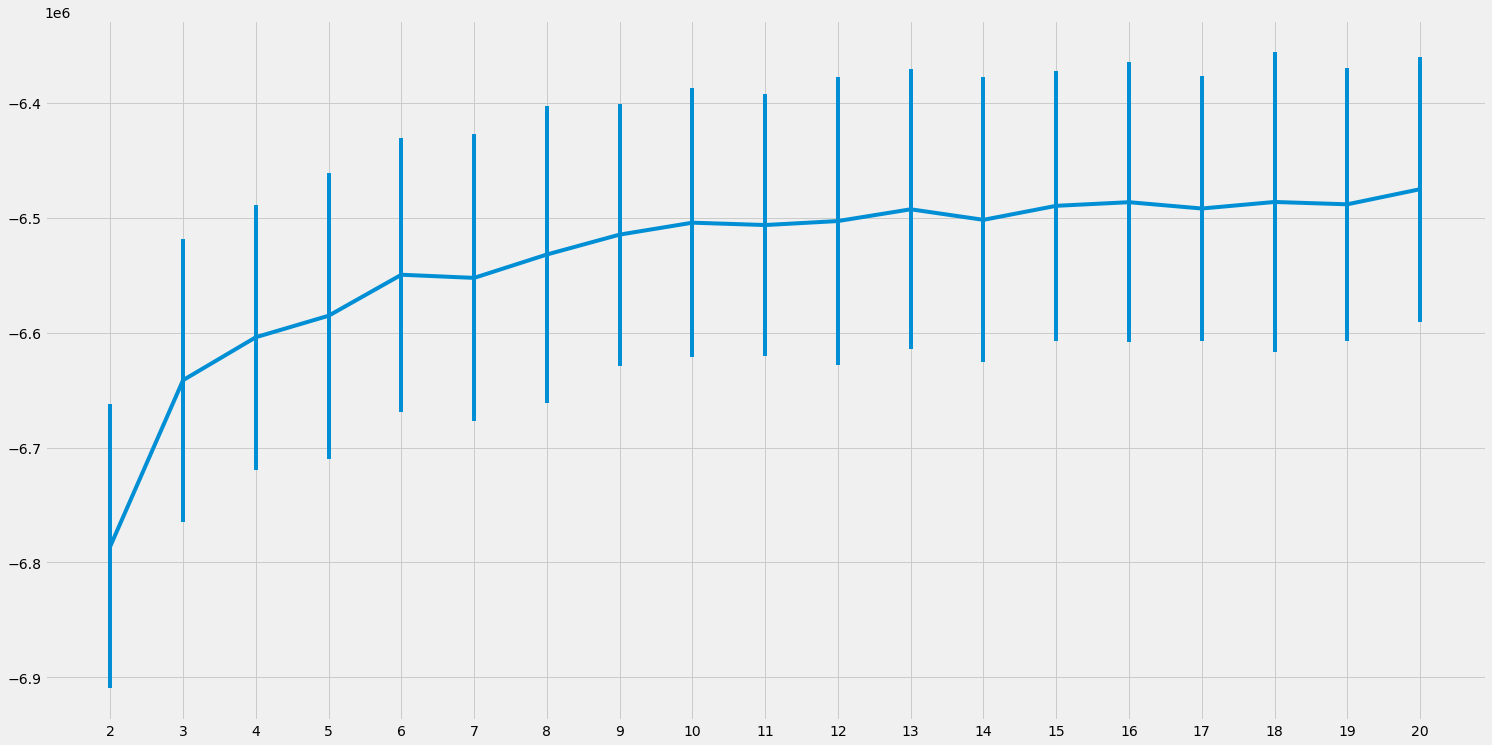

In [318]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=[23,12])
k_grid_results = pd.DataFrame(k_grid_cv.cv_results_)
plt.errorbar(np.arange(2,21), k_grid_results['mean_test_score'], yerr=k_grid_results['std_test_score'])
plt.grid(True)
# plt.yticks(np.arange(-6.9e6, -6.3e6, 0.05e6))
plt.xticks(np.arange(2,21));

In [319]:
kmax = 20
sil = []
iner = []
for k in range(2, kmax+1):
  kmeansmodel = KMeans(n_clusters = k).fit(docWord)
  labels = kmeansmodel.labels_
  inertia = kmeansmodel.inertia_
  sil.append(silhouette_score(docWord, labels, metric = 'euclidean'))
  iner.append(kmeansmodel.inertia_)

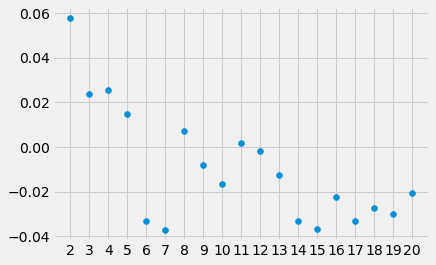

In [320]:
plt.scatter(np.arange(2,21), sil)
plt.grid(True)
plt.xticks(np.arange(2,21));

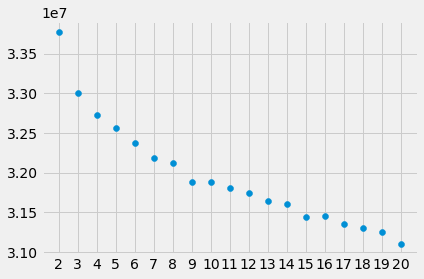

In [321]:
plt.scatter(np.arange(2,21), iner)
plt.grid(True)
plt.xticks(np.arange(2,21));

It's not immediately clear which k value is optimal due to the lack of elbows in the inertia plot or silhouette peaks. However, a k value of 7 appears to form a slight elbow, a local silhouette peak, and somewhat comparable results to cross validation (which returned an optimal k of 5). We shall proceed with this value.

In [322]:
x_mean = pd.DataFrame(docWord).describe().loc['mean']
print(x_mean)

0       6.121581
1       3.394095
2       9.015467
3       7.278490
4       8.952740
          ...   
5471   -0.534182
5472   -0.604428
5473   -0.504000
5474   -0.582830
5475   -0.569696
Name: mean, Length: 5476, dtype: float64


In [323]:
n_clusters = 6
selected_kmeans = KMeans(n_clusters=n_clusters).fit(docWord)
labels = selected_kmeans.labels_
cluster_centers = selected_kmeans.cluster_centers_
subtracted = cluster_centers - x_mean.to_numpy()

In [324]:
farthest = np.zeros([n_clusters,10])
word_list = open('science2k-vocab.txt','r').read().split()

for index, row in pd.DataFrame(subtracted).iterrows():
    descending_sorted = np.argsort(-row)
    farthest[index,:] = descending_sorted[0:10]

farthest_words = np.empty([n_clusters,10], dtype='<U20')

for cluster in range(n_clusters):
    farthest_words[cluster,:] = [word_list[i] for i in farthest[cluster,:].astype('int').tolist()]

pd.DataFrame(farthest_words)

,0,1,2,3,4,5,6,7,8,9
0,global,values,estimates,surface,north,years,estimate,lower,range,temperature
1,cells,expression,cell,protein,fig,expressed,wild,gene,control,induced
2,fig,energy,shows,measured,electron,constant,density,order,solid,reports
3,says,researchers,scientists,year,people,just,get,research,last,years
4,mail,compass,author,issue,page,sciences,news,years,article,policy
5,protein,sequence,conserved,amino,domain,binding,acid,proteins,residues,site


In [340]:
print(pd.DataFrame(farthest_words).to_latex())

\begin{tabular}{lllllllllll}
\toprule
{} &        0 &            1 &           2 &         3 &         4 &          5 &         6 &         7 &         8 &            9 \\
\midrule
0 &   global &       values &   estimates &   surface &     north &      years &  estimate &     lower &     range &  temperature \\
1 &    cells &   expression &        cell &   protein &       fig &  expressed &      wild &      gene &   control &      induced \\
2 &      fig &       energy &       shows &  measured &  electron &   constant &   density &     order &     solid &      reports \\
3 &     says &  researchers &  scientists &      year &    people &       just &       get &  research &      last &        years \\
4 &     mail &      compass &      author &     issue &      page &   sciences &      news &     years &   article &       policy \\
5 &  protein &     sequence &   conserved &     amino &    domain &    binding &      acid &  proteins &  residues &         site \\
\bottomrule
\end{tabu

In [326]:
from scipy.spatial import distance
title_list = open('science2k-titles.txt','r').read().split('\n')
title_list.append('Cluster size limited')

n_documents = len(selected_kmeans.labels_)
distances_to_center = np.zeros([n_documents,2])

for document in range(n_documents):
    cluster = selected_kmeans.labels_[document]
    cluster_center = cluster_centers[cluster]
    distances_to_center[document,0] = cluster
    distances_to_center[document,1] = distance.euclidean(cluster_center, docWord[document])

distances_to_center = pd.DataFrame(distances_to_center)

closest_documents = np.empty([n_clusters,10])
closest_documents[:] = np.NaN

for cluster in range(n_clusters):
    distances_per_cluster = distances_to_center.loc[distances_to_center[0] == cluster][1]
    closest = np.argsort(distances_per_cluster)[0:10].index.to_numpy()
    if len(closest) < 10:
        append = np.zeros([10 - len(closest),1])
        append[:] = len(title_list) - 1
        closest = np.append(closest, append)
    closest_documents[cluster,:] = closest

In [327]:
a = distances_to_center.loc[distances_to_center[0] == 1]
np.argsort(a)[0:10].index.to_numpy()

array([27, 28, 29, 30, 32, 41, 52, 53, 56, 58], dtype=int64)

In [328]:
closest_titles = np.empty([n_clusters,10], dtype='<U100')

for cluster in range(n_clusters):
    closest_titles[cluster,:] = [title_list[i] for i in closest_documents[cluster,:].astype('int').tolist()]

pd.DataFrame(closest_titles)

,0,1,2,3,4,5,6,7,8,9
0,"""The Formation and Early Evolution of the Milk...","""The Dark Halo of the Milky Way""","""The Baryon Halo of the Milky Way: A Fossil Re...","""The Galactic Center: An Interacting System of...","""Evidence for Crystalline Water and Ammonia Ic...","""The Changing Morphology and Increasing Decele...","""Cenozoic Deep-Sea Temperatures and Global Ice...","""Rutile-Bearing Refractory Eclogites: Missing ...","""Late Cretaceous Polar Wander of the Pacific P...","""The Role of the Southern Ocean in Uptake and ..."
1,"""Modulation of Brain Reward Circuitry by Leptin""","""Sex Determination in Malaria Parasites""","""DNA Topoisomerase IIb and Neural Development""","""Tbx5 and the Retinotectum Projection""","""Stat3-Mediated Transformation of NIH-3T3 Cell...","""Memory-A Century of Consolidation""","""Regulation of Abscisic Acid-Induced Stomatal ...","""Engineering the Provitamin A (b-Carotene) Bio...","""A Population of Murine gd T Cells That Recogn...","""Severely Reduced Female Fertility in CD9-Defi..."
2,"""Generating Solitons by Phase Engineering of a...","""Equilibrium Regained: From Nonequilibrium Cha...","""Evidence for a Low-Density Universe from the ...","""A Short Fe-Fe Distance in Peroxodiferric Ferr...","""Organizing Principles for a Diversity of GABA...","""Reaction of Plutonium Dioxide with Water: For...","""Communication through a Diffusive Medium: Coh...","""Direct Observation of Dynamical Heterogeneiti...","""Formation of Cyclic Water Hexamer in Liquid H...","""Distal Initiation and Active Propagation of A..."
3,"""A Crushing End for Our Galaxy""","""Designer Labs: Architecture Discovers Science""","""Deconstructing the Science Wars by Reconstruc...","""Reaping the Plant Gene Harvest""","""Graduate Educators Struggle to Grade Themselves""","""Support Grows for British Exercise to Allocat...","""Earthmovers of the Amazon""","""Consumer Power Heralds Hard Times for Researc...","""Balancing the Science Budget""","""Solar Missions Brighten NASA's Hopes for Spac..."
4,"""Archaeology in the Holy Land""","""Baedeker's Guide, or Just Plain 'Trouble'?""","""Duchamp's L.H.O.O.Q.-From 1919 or 1930?""","""Resistance to Bt Toxins""","""Corrections and Clarifications: Commercializa...","""Corrections and Clarifications: First-Princip...","""Will Tribal Knowledge Survive the Millennium?""","""Brane-Worlds""","""Tracing the Origins of Salmonella Outbreaks""","""Reading the Worm Genome"""
5,"""Structural Basis of Smad2 Recognition by the ...","""Protein Interaction Mapping in C. elegans Usi...","""A Mammalian <latex>$H^+$</latex> Channel Gene...","""Crystal Structure of gd T Cell Receptor Ligan...","""One Polypeptide with Two Aminoacyl-tRNA Synth...","""AIDS as a Zoonosis: Scientific and Public Hea...","""Redox Signaling in Chloroplasts: Cleavage of ...","""Adaptive Recognition by Nucleic Acid Aptamers""","""Mutations in SDHD, A Mitochondrial Complex II...","""Conservation and Novelty in the Evolution of ..."


In [341]:
print(pd.DataFrame(closest_titles).to_latex())

\begin{tabular}{lllllllllll}
\toprule
{} &                                                  0 &                                                  1 &                                                  2 &                                                  3 &                                                  4 &                                                  5 &                                                  6 &                                                  7 &                                                  8 &                                                  9 \\
\midrule
0 &  "The Formation and Early Evolution of the Milk... &                   "The Dark Halo of the Milky Way" &  "The Baryon Halo of the Milky Way: A Fossil Re... &  "The Galactic Center: An Interacting System of... &  "Evidence for Crystalline Water and Ammonia Ic... &  "The Changing Morphology and Increasing Decele... &  "Cenozoic Deep-Sea Temperatures and Global Ice... &  "Rutile-Bearing Refractory Eclogites: Mis

### Term-wise clustering

In [349]:
wordDoc = np.load("science2k-word-doc.npy")

kmax = 20
sil = []
iner = []
for k in range(2, kmax+1):
  kmeansmodel = KMeans(n_clusters = k).fit(wordDoc)
  labels = kmeansmodel.labels_
  inertia = kmeansmodel.inertia_
  sil.append(silhouette_score(wordDoc, labels, metric = 'euclidean'))
  iner.append(kmeansmodel.inertia_)

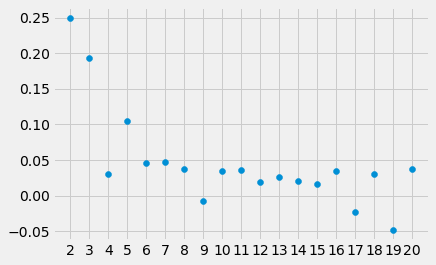

In [350]:
plt.scatter(np.arange(2,21), sil)
plt.grid(True)
plt.xticks(np.arange(2,21));

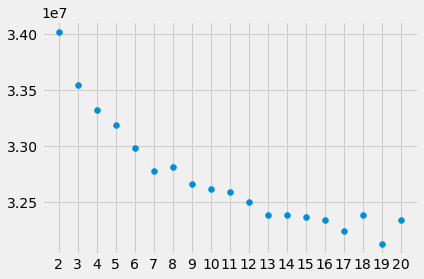

In [351]:
plt.scatter(np.arange(2,21), iner)
plt.grid(True)
plt.xticks(np.arange(2,21));

In [352]:
x_mean = pd.DataFrame(wordDoc).describe().loc['mean']

In [369]:
selected_kmeans = KMeans(n_clusters=n_clusters).fit(wordDoc)
labels = selected_kmeans.labels_
cluster_centers = selected_kmeans.cluster_centers_
subtracted = cluster_centers - x_mean.to_numpy()

In [370]:
farthest = np.zeros([n_clusters,10])

for index, row in pd.DataFrame(subtracted).iterrows():
    descending_sorted = np.argsort(-row)
    farthest[index,:] = descending_sorted[0:10]

farthest_titles = np.empty([n_clusters,10], dtype='<U100')

for cluster in range(n_clusters):
    farthest_titles[cluster,:] = [title_list[i] for i in farthest[cluster,:].astype('int').tolist()]

pd.DataFrame(farthest_titles)

,0,1,2,3,4,5,6,7,8,9
0,"""A New Breed of Scientist-Advocate Emerges""","""Sharp Jump in Teaching Fellows Draws Fire fro...","""Soft Money's Hard Realities""","""Balancing the Collaboration Equation""","""The Boom in Biosafety Labs""","""South Africa's New Enemy""","""Africa Boosts AIDS Vaccine R&D""","""Meltdown on Long Island""","""NIH, under Pressure, Boosts Minority Health R...","""Ground Zero: AIDS Research in Africa"""
1,"""Regulated Cleavage of a Contact-Mediated Axon...","""Positional Syntenic Cloning and Functional Ch...","""Noxa, a BH3-Only Member of the Bcl-2 Family a...","""Role of the Mouse ank Gene in Control of Tiss...","""Regulation of STAT3 by Direct Binding to the ...","""Ubiquitin Protein Ligase Activity of IAPs and...","""Signaling and Circuitry of Multiple MAPK Path...","""Kinesin Superfamily Motor Protein KIF17 and m...","""Central Role for G Protein-Coupled Phosphoino...","""Cytochrome c Release and Apoptosis Induced by..."
2,"""Advances in the Physics of High-Temperature S...","""Quantum Criticality: Competing Ground States ...","""The Atom-Cavity Microscope: Single Atoms Boun...","""Orbital Physics in Transition-Metal Oxides""","""Negative Poisson's Ratios for Extreme States ...","""Self-Mode-Locking of Quantum Cascade Lasers w...","""The Galactic Center: An Interacting System of...","""Generating Solitons by Phase Engineering of a...","""The Formation and Early Evolution of the Milk...","""Subatomic Features on the Silicon (111)-(7 x ..."
3,"""Central Role for G Protein-Coupled Phosphoino...","""Function of PI3Kg in Thymocyte Development, T...","""An Oral Vaccine against NMDAR1 with Efficacy ...","""Noxa, a BH3-Only Member of the Bcl-2 Family a...","""Kinesin Superfamily Motor Protein KIF17 and m...","""Role of the Mouse ank Gene in Control of Tiss...","""Comparative Genomics of the Eukaryotes""","""Requirement of JNK for Stress-Induced Activat...","""Immune Inhibitory Receptors""","""Requirement for RORg in Thymocyte Survival an..."
4,"""Climate Extremes: Observations, Modeling, and...","""Status and Improvements of Coupled General Ci...","""The Global Carbon Cycle: A Test of Our Knowle...","""Sedimentary Rocks of Early Mars""","""A 22,000-Year Record of Monsoonal Precipitati...","""Rapid Changes in the Hydrologic Cycle of the ...","""Coherent High- and Low-Latitude Climate Varia...","""Causes of Climate Change over the past 1000 Y...","""Is El Nino Changing?""","""The Ascent of Atmospheric Sciences"""
5,"""NEAR at Eros: Imaging and Spectral Results""","""The Atom-Cavity Microscope: Single Atoms Boun...","""Advances in the Physics of High-Temperature S...","""Reduction of Tropical Cloudiness by Soot""","""Internal Structure and Early Thermal Evolutio...","""Architecture of RNA Polymerase II and Implica...","""Sediments at the Top of Earth's Core""","""Rocks from the Mantle Transition Zone: Majori...","""Experiments and Simulations of Ion-Enhanced I...","""Climate Extremes: Observations, Modeling, and..."


In [371]:
print(pd.DataFrame(farthest_titles).to_latex())

\begin{tabular}{lllllllllll}
\toprule
{} &                                                  0 &                                                  1 &                                                  2 &                                                  3 &                                                  4 &                                                  5 &                                                  6 &                                                  7 &                                                  8 &                                                  9 \\
\midrule
0 &        "A New Breed of Scientist-Advocate Emerges" &  "Sharp Jump in Teaching Fellows Draws Fire fro... &                      "Soft Money's Hard Realities" &             "Balancing the Collaboration Equation" &                       "The Boom in Biosafety Labs" &                         "South Africa's New Enemy" &                   "Africa Boosts AIDS Vaccine R\&D" &                          "Meltdown on Lon

In [372]:
word_list.append('Cluster size limited')

n_words = len(selected_kmeans.labels_)
distances_to_center = np.zeros([n_words,2])

for word in range(n_words):
    cluster = selected_kmeans.labels_[word]
    cluster_center = cluster_centers[cluster]
    distances_to_center[word,0] = cluster
    distances_to_center[word,1] = distance.euclidean(cluster_center, wordDoc[word])

distances_to_center = pd.DataFrame(distances_to_center)

closest_words = np.empty([n_clusters,10])
closest_words[:] = np.NaN

for cluster in range(n_clusters):
    distances_per_cluster = distances_to_center.loc[distances_to_center[0] == cluster][1]
    closest = np.argsort(distances_per_cluster)[0:10].index.to_numpy()
    if len(closest) < 10:
        append = np.zeros([10 - len(closest),1])
        append[:] = len(word_list) - 1
        closest = np.append(closest, append)
    closest_words[cluster,:] = closest

In [373]:
closest_words_written = np.empty([n_clusters,10], dtype='<U100')

for cluster in range(n_clusters):
    closest_words_written[cluster,:] = [word_list[i] for i in closest_words[cluster,:].astype('int').tolist()]

pd.DataFrame(closest_words_written)

,0,1,2,3,4,5,6,7,8,9
0,science,end,university,says,work,national,institute,researchers,hiv,life
1,cells,cell,protein,dna,gene,mice,proteins,expression,type,genes
2,first,system,state,energy,field,like,right,important,electron,light
3,org,www,sciencemag,vol,usa,group,development,neurons,genome,animals
4,time,new,research,years,species,long,water,year,based,see
5,fig,two,data,start,high,surface,observed,shown,different,results


In [374]:
print(pd.DataFrame(closest_words_written).to_latex())

\begin{tabular}{lllllllllll}
\toprule
{} &        0 &       1 &           2 &       3 &        4 &         5 &            6 &            7 &          8 &        9 \\
\midrule
0 &  science &     end &  university &    says &     work &  national &    institute &  researchers &        hiv &     life \\
1 &    cells &    cell &     protein &     dna &     gene &      mice &     proteins &   expression &       type &    genes \\
2 &    first &  system &       state &  energy &    field &      like &        right &    important &   electron &    light \\
3 &      org &     www &  sciencemag &     vol &      usa &     group &  development &      neurons &     genome &  animals \\
4 &     time &     new &    research &   years &  species &      long &        water &         year &      based &      see \\
5 &      fig &     two &        data &   start &     high &   surface &     observed &        shown &  different &  results \\
\bottomrule
\end{tabular}



In [363]:
distances_to_center.loc[distances_to_center[0] == 0][1][0:10]

1063    2.799876e-15
Name: 1, dtype: float64